## $$\color{red}{\text{Nima Modirkiasaraee - 810102339}}$$
## $$\color{red}{\text{Question2: Robustness}}$$


In [1]:
!pip install cleverhans
!pip install umap-learn
!pip install pytorch_metric_learning

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.3/92.3 kB 2.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.1/119.1 kB 3.8 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl 

In [2]:
import torch
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset, random_split
from sklearn.model_selection import train_test_split
import numpy as np
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from cleverhans.torch.attacks.fast_gradient_method import fast_gradient_method
import matplotlib.pyplot as plt
import umap
from pytorch_metric_learning import losses
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [3]:
transform = transforms.Compose([
    transforms.Resize(224),  # Resize images to fit ResNet18's expected input size
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the CIFAR10 dataset
dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
val_size = 10000
train_size = len(dataset) - val_size
train_dataset, valid_dataset = random_split(dataset, [train_size, val_size])

100%|██████████| 170498071/170498071 [00:04<00:00, 35075598.51it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [4]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.resnet18(pretrained=True)
num_classes = 10
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 82.5MB/s]


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


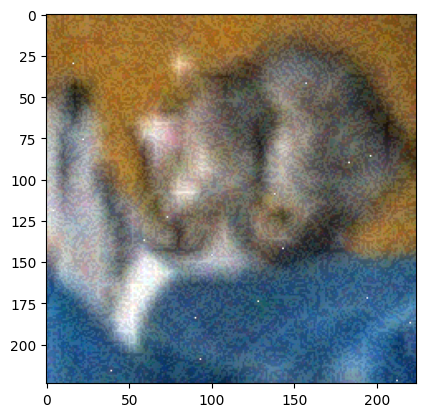

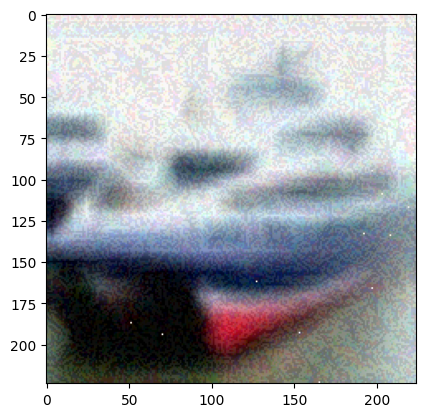

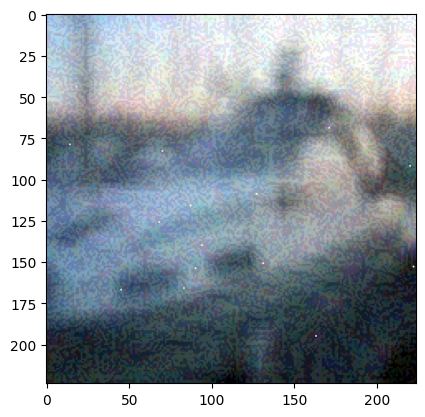

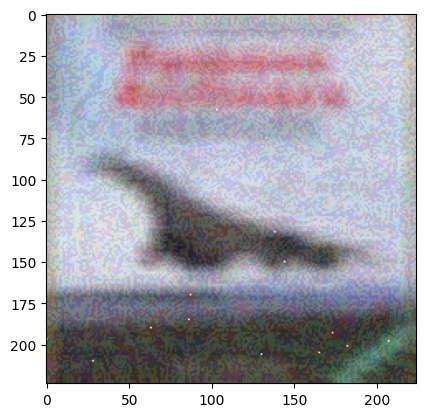

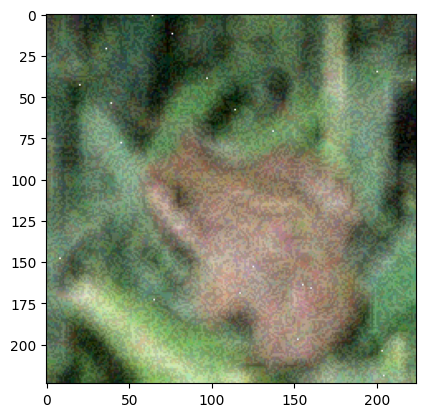

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
def add_noise(batch):
  output_tensors = []
  for image in batch:
    C, H, W = image.shape
    for _ in range(20):
        # Randomly choose a pixel
        h, w = np.random.randint(0, H), np.random.randint(0, W)
        # Change the pixel color to white
        image[:, h, w] = torch.tensor([1.0, 1.0, 1.0])
    output_tensors.append(image)
  return torch.stack(output_tensors, 0)

model.eval()
epsilon = 0.1
for data in test_loader:
  images, labels = data
  images, labels = images.to(device), labels.to(device)
  data_fgm = fast_gradient_method(model, add_noise(images), epsilon, np.inf)
  for i in range(5):
    img = data_fgm[i].cpu() / 2 + 0.5
    plt.imshow(np.transpose(img.detach().numpy(), (1, 2, 0)))
    plt.show()
  break

## Train model on original dataset with CrossEntropy loss function

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 25

# Initialize lists for plotting
train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []

for epoch in range(epochs):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    # epoch_acc = 100. * (train_running_correct / len(trainloader.dataset))
    epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    model.eval()
    print('Validation')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    with torch.no_grad():
        for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
            counter += 1
            image, labels = data
            image = image.to(device)
            labels = labels.to(device)
            # Forward pass.
            outputs = model(image)
            # Calculate the loss.
            loss = criterion(outputs, labels)
            valid_running_loss += loss.item()
            # Calculate the accuracy.
            _, preds = torch.max(outputs.data, 1)
            valid_running_correct += (preds == labels).sum().item()
    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(valid_loader.dataset))
    val_losses.append(epoch_loss)
    val_accuracies.append(epoch_acc)

    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_accuracies[-1]:.2f}%')

Training


100%|██████████| 313/313 [02:00<00:00,  2.60it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  4.01it/s]

Epoch 1, Train Loss: 0.5009, Train Acc: 82.94%, Val Loss: 0.3918, Val Acc: 86.72%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]

Validation



100%|██████████| 79/79 [00:18<00:00,  4.17it/s]

Epoch 2, Train Loss: 0.2669, Train Acc: 90.87%, Val Loss: 0.3547, Val Acc: 88.08%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]

Validation



100%|██████████| 79/79 [00:18<00:00,  4.19it/s]

Epoch 3, Train Loss: 0.1788, Train Acc: 93.73%, Val Loss: 0.3777, Val Acc: 88.02%
Training



100%|██████████| 313/313 [01:57<00:00,  2.65it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  4.13it/s]

Epoch 4, Train Loss: 0.1283, Train Acc: 95.55%, Val Loss: 0.3897, Val Acc: 88.36%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]

Validation



100%|██████████| 79/79 [00:18<00:00,  4.16it/s]

Epoch 5, Train Loss: 0.0916, Train Acc: 96.86%, Val Loss: 0.3905, Val Acc: 88.91%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  4.06it/s]

Epoch 6, Train Loss: 0.0736, Train Acc: 97.44%, Val Loss: 0.3871, Val Acc: 88.85%
Training



100%|██████████| 313/313 [01:57<00:00,  2.67it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  4.01it/s]

Epoch 7, Train Loss: 0.0674, Train Acc: 97.61%, Val Loss: 0.3231, Val Acc: 90.55%
Training



100%|██████████| 313/313 [01:57<00:00,  2.67it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  3.96it/s]

Epoch 8, Train Loss: 0.0583, Train Acc: 98.02%, Val Loss: 0.3197, Val Acc: 91.42%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  3.99it/s]

Epoch 9, Train Loss: 0.0397, Train Acc: 98.62%, Val Loss: 0.3509, Val Acc: 90.39%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  3.98it/s]

Epoch 10, Train Loss: 0.0416, Train Acc: 98.58%, Val Loss: 0.3861, Val Acc: 90.49%
Training



100%|██████████| 313/313 [01:57<00:00,  2.67it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  4.06it/s]

Epoch 11, Train Loss: 0.0587, Train Acc: 98.00%, Val Loss: 0.4301, Val Acc: 89.06%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]

Validation



100%|██████████| 79/79 [00:18<00:00,  4.17it/s]

Epoch 12, Train Loss: 0.0304, Train Acc: 98.99%, Val Loss: 0.4307, Val Acc: 89.81%
Training



100%|██████████| 313/313 [01:57<00:00,  2.65it/s]

Validation



100%|██████████| 79/79 [00:18<00:00,  4.18it/s]

Epoch 13, Train Loss: 0.0286, Train Acc: 99.05%, Val Loss: 0.4284, Val Acc: 89.90%
Training



100%|██████████| 313/313 [01:57<00:00,  2.67it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  4.14it/s]

Epoch 14, Train Loss: 0.0443, Train Acc: 98.56%, Val Loss: 0.4054, Val Acc: 90.25%
Training



100%|██████████| 313/313 [02:07<00:00,  2.46it/s]

Validation



100%|██████████| 79/79 [00:22<00:00,  3.51it/s]

Epoch 15, Train Loss: 0.0303, Train Acc: 98.95%, Val Loss: 0.4542, Val Acc: 89.61%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  4.00it/s]

Epoch 16, Train Loss: 0.0377, Train Acc: 98.71%, Val Loss: 0.4019, Val Acc: 90.40%
Training



100%|██████████| 313/313 [01:58<00:00,  2.65it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  3.96it/s]

Epoch 17, Train Loss: 0.0252, Train Acc: 99.15%, Val Loss: 0.3852, Val Acc: 91.04%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  3.98it/s]

Epoch 18, Train Loss: 0.0310, Train Acc: 98.98%, Val Loss: 0.3556, Val Acc: 91.29%
Training



100%|██████████| 313/313 [01:57<00:00,  2.67it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  3.99it/s]

Epoch 19, Train Loss: 0.0182, Train Acc: 99.41%, Val Loss: 0.4576, Val Acc: 90.30%
Training



100%|██████████| 313/313 [01:57<00:00,  2.67it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  4.01it/s]

Epoch 20, Train Loss: 0.0366, Train Acc: 98.81%, Val Loss: 0.3761, Val Acc: 91.24%
Training



100%|██████████| 313/313 [01:57<00:00,  2.67it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  4.08it/s]

Epoch 21, Train Loss: 0.0152, Train Acc: 99.50%, Val Loss: 0.5018, Val Acc: 89.99%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  4.06it/s]

Epoch 22, Train Loss: 0.0321, Train Acc: 98.95%, Val Loss: 0.4267, Val Acc: 90.54%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  4.15it/s]

Epoch 23, Train Loss: 0.0247, Train Acc: 99.19%, Val Loss: 0.3723, Val Acc: 91.36%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]

Validation



100%|██████████| 79/79 [00:18<00:00,  4.17it/s]

Epoch 24, Train Loss: 0.0162, Train Acc: 99.43%, Val Loss: 0.4168, Val Acc: 91.00%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]

Validation



100%|██████████| 79/79 [00:19<00:00,  4.14it/s]

Epoch 25, Train Loss: 0.0245, Train Acc: 99.20%, Val Loss: 0.5298, Val Acc: 89.54%


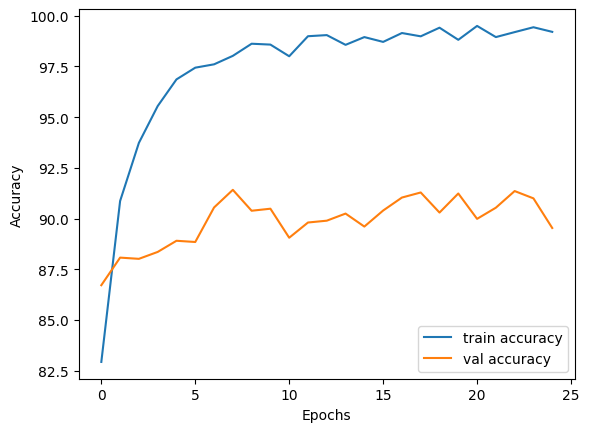

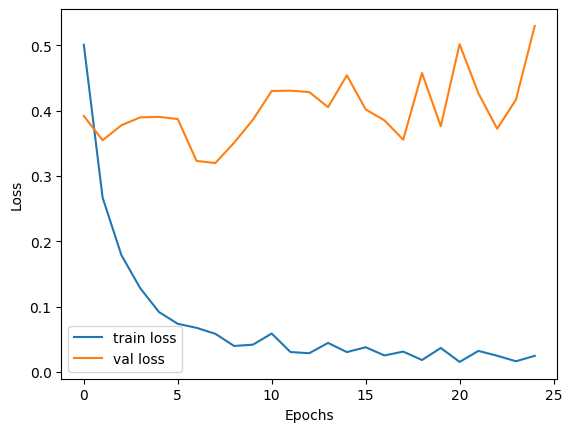

In [ ]:
import matplotlib.pyplot as plt
plt.plot(train_accuracies,label='train accuracy')
plt.plot(val_accuracies,label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(train_losses,label='train loss')
plt.plot(val_losses,label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

In [ ]:
def add_noise(batch):
  output_tensors = []
  for image in batch:
    C, H, W = image.shape
    for _ in range(20):
        # Randomly choose a pixel
        h, w = np.random.randint(0, H), np.random.randint(0, W)
        # Change the pixel color to white
        image[:, h, w] = torch.tensor([1.0, 1.0, 1.0])
    output_tensors.append(image)
  return torch.stack(output_tensors, 0)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 25
epsilon = 0.1

# Initialize lists for plotting
train_losses, val_losses_original, val_losses_adversarial, train_accuracies, val_accuracies_original, val_accuracies_adversarial = [], [], [], [], [], []

for epoch in range(epochs):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    model.eval()
    print()
    print('Validation on original images')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        ### Original Validation images ###
        outputs = model(image)
        loss = criterion(outputs, labels)
        valid_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(valid_loader.dataset))
    val_losses_original.append(epoch_loss)
    val_accuracies_original.append(epoch_acc)

    print()
    print('Validation on adversarial images')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        ### Adversarial Validation images ###
        data_fgm = fast_gradient_method(model, add_noise(image), epsilon, np.inf)
        outputs = model(data_fgm)
        loss = criterion(outputs, labels)
        valid_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(valid_loader.dataset))
    val_losses_adversarial.append(epoch_loss)
    val_accuracies_adversarial.append(epoch_acc)

    print()
    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss_original: {val_losses_original[-1]:.4f}, Val Acc_original: {val_accuracies_original[-1]:.2f}%, Val Loss_adversarial: {val_losses_adversarial[-1]:.4f}, Val Acc_adversarial: {val_accuracies_adversarial[-1]:.2f}%')

Training


100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


Validation on original images



100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:08<00:00,  1.15it/s]


Epoch 1, Train Loss: 0.2124, Train Acc: 92.52%, Val Loss_original: 0.3556, Val Acc_original: 88.68%, Val Loss_adversarial: 4.8642, Val Acc_adversarial: 8.98%
Training



100%|██████████| 313/313 [01:56<00:00,  2.70it/s]


Validation on original images



100%|██████████| 79/79 [00:19<00:00,  4.00it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]


Epoch 2, Train Loss: 0.1238, Train Acc: 95.70%, Val Loss_original: 0.3527, Val Acc_original: 89.30%, Val Loss_adversarial: 5.1254, Val Acc_adversarial: 9.38%
Training



100%|██████████| 313/313 [01:56<00:00,  2.70it/s]


Validation on original images



100%|██████████| 79/79 [00:19<00:00,  4.10it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:08<00:00,  1.15it/s]


Epoch 3, Train Loss: 0.0974, Train Acc: 96.51%, Val Loss_original: 0.3163, Val Acc_original: 90.21%, Val Loss_adversarial: 6.2820, Val Acc_adversarial: 7.52%
Training



100%|██████████| 313/313 [01:56<00:00,  2.70it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.89it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]


Epoch 4, Train Loss: 0.0699, Train Acc: 97.52%, Val Loss_original: 0.4541, Val Acc_original: 87.36%, Val Loss_adversarial: 8.3393, Val Acc_adversarial: 9.10%
Training



100%|██████████| 313/313 [01:56<00:00,  2.69it/s]


Validation on original images



100%|██████████| 79/79 [00:19<00:00,  4.11it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]


Epoch 5, Train Loss: 0.0601, Train Acc: 97.94%, Val Loss_original: 0.3747, Val Acc_original: 90.30%, Val Loss_adversarial: 7.8044, Val Acc_adversarial: 8.29%
Training



100%|██████████| 313/313 [01:56<00:00,  2.69it/s]


Validation on original images



100%|██████████| 79/79 [00:19<00:00,  3.98it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:08<00:00,  1.16it/s]


Epoch 6, Train Loss: 0.0418, Train Acc: 98.55%, Val Loss_original: 0.4079, Val Acc_original: 89.09%, Val Loss_adversarial: 7.1444, Val Acc_adversarial: 10.03%
Training



100%|██████████| 313/313 [01:56<00:00,  2.68it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.64it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.09it/s]


Epoch 7, Train Loss: 0.0482, Train Acc: 98.39%, Val Loss_original: 0.3904, Val Acc_original: 90.11%, Val Loss_adversarial: 8.6289, Val Acc_adversarial: 9.25%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.62it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Epoch 8, Train Loss: 0.0469, Train Acc: 98.41%, Val Loss_original: 0.3689, Val Acc_original: 90.30%, Val Loss_adversarial: 9.8603, Val Acc_adversarial: 7.99%
Training



100%|██████████| 313/313 [01:57<00:00,  2.67it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.61it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Epoch 9, Train Loss: 0.0293, Train Acc: 98.99%, Val Loss_original: 0.3873, Val Acc_original: 90.86%, Val Loss_adversarial: 9.1840, Val Acc_adversarial: 7.23%
Training



100%|██████████| 313/313 [01:57<00:00,  2.67it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.63it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:10<00:00,  1.11it/s]


Epoch 10, Train Loss: 0.0408, Train Acc: 98.60%, Val Loss_original: 0.4641, Val Acc_original: 89.52%, Val Loss_adversarial: 7.5032, Val Acc_adversarial: 9.70%
Training



100%|██████████| 313/313 [01:57<00:00,  2.67it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.79it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.10it/s]



Epoch 11, Train Loss: 0.0299, Train Acc: 99.00%, Val Loss_original: 0.5251, Val Acc_original: 88.27%, Val Loss_adversarial: 9.1738, Val Acc_adversarial: 9.18%
Training


100%|██████████| 313/313 [01:57<00:00,  2.67it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.64it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch 12, Train Loss: 0.0345, Train Acc: 98.83%, Val Loss_original: 0.4000, Val Acc_original: 91.42%, Val Loss_adversarial: 10.6514, Val Acc_adversarial: 6.63%
Training



100%|██████████| 313/313 [01:56<00:00,  2.68it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.63it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch 13, Train Loss: 0.0187, Train Acc: 99.33%, Val Loss_original: 0.4408, Val Acc_original: 89.85%, Val Loss_adversarial: 8.4834, Val Acc_adversarial: 9.37%
Training



100%|██████████| 313/313 [01:56<00:00,  2.68it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.62it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch 14, Train Loss: 0.0395, Train Acc: 98.67%, Val Loss_original: 0.4154, Val Acc_original: 90.64%, Val Loss_adversarial: 10.8491, Val Acc_adversarial: 8.08%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.09it/s]


Epoch 15, Train Loss: 0.0311, Train Acc: 99.01%, Val Loss_original: 0.4046, Val Acc_original: 90.52%, Val Loss_adversarial: 9.3733, Val Acc_adversarial: 9.26%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


Validation on original images



100%|██████████| 79/79 [00:22<00:00,  3.52it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.10it/s]


Epoch 16, Train Loss: 0.0149, Train Acc: 99.50%, Val Loss_original: 0.4675, Val Acc_original: 90.25%, Val Loss_adversarial: 9.6344, Val Acc_adversarial: 8.32%
Training



100%|██████████| 313/313 [01:57<00:00,  2.67it/s]


Validation on original images



100%|██████████| 79/79 [00:22<00:00,  3.59it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch 17, Train Loss: 0.0230, Train Acc: 99.25%, Val Loss_original: 0.4142, Val Acc_original: 91.00%, Val Loss_adversarial: 8.8760, Val Acc_adversarial: 8.64%
Training



100%|██████████| 313/313 [01:57<00:00,  2.68it/s]


Validation on original images



100%|██████████| 79/79 [00:22<00:00,  3.58it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch 18, Train Loss: 0.0217, Train Acc: 99.28%, Val Loss_original: 0.4336, Val Acc_original: 90.82%, Val Loss_adversarial: 7.9416, Val Acc_adversarial: 8.93%
Training



100%|██████████| 313/313 [01:56<00:00,  2.68it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.74it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:10<00:00,  1.11it/s]


Epoch 19, Train Loss: 0.0274, Train Acc: 99.07%, Val Loss_original: 0.4291, Val Acc_original: 90.62%, Val Loss_adversarial: 9.4714, Val Acc_adversarial: 8.50%
Training



100%|██████████| 313/313 [01:56<00:00,  2.68it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:10<00:00,  1.12it/s]


Epoch 20, Train Loss: 0.0191, Train Acc: 99.27%, Val Loss_original: 0.4441, Val Acc_original: 90.57%, Val Loss_adversarial: 9.2703, Val Acc_adversarial: 7.71%
Training



100%|██████████| 313/313 [01:56<00:00,  2.68it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.68it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:10<00:00,  1.11it/s]


Epoch 21, Train Loss: 0.0217, Train Acc: 99.27%, Val Loss_original: 0.4600, Val Acc_original: 90.34%, Val Loss_adversarial: 8.3515, Val Acc_adversarial: 8.92%
Training



100%|██████████| 313/313 [01:56<00:00,  2.69it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.71it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:10<00:00,  1.12it/s]


Epoch 22, Train Loss: 0.0261, Train Acc: 99.19%, Val Loss_original: 0.4080, Val Acc_original: 91.04%, Val Loss_adversarial: 8.4643, Val Acc_adversarial: 8.05%
Training



100%|██████████| 313/313 [01:56<00:00,  2.68it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.72it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:11<00:00,  1.11it/s]


Epoch 23, Train Loss: 0.0182, Train Acc: 99.43%, Val Loss_original: 0.4118, Val Acc_original: 91.12%, Val Loss_adversarial: 8.1292, Val Acc_adversarial: 9.81%
Training



100%|██████████| 313/313 [01:57<00:00,  2.66it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.71it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.09it/s]


Epoch 24, Train Loss: 0.0129, Train Acc: 99.60%, Val Loss_original: 0.4255, Val Acc_original: 91.06%, Val Loss_adversarial: 9.5768, Val Acc_adversarial: 8.16%
Training



100%|██████████| 313/313 [01:57<00:00,  2.67it/s]


Validation on original images



100%|██████████| 79/79 [00:22<00:00,  3.55it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.09it/s]


Epoch 25, Train Loss: 0.0189, Train Acc: 99.39%, Val Loss_original: 0.4357, Val Acc_original: 91.10%, Val Loss_adversarial: 10.2002, Val Acc_adversarial: 8.07%


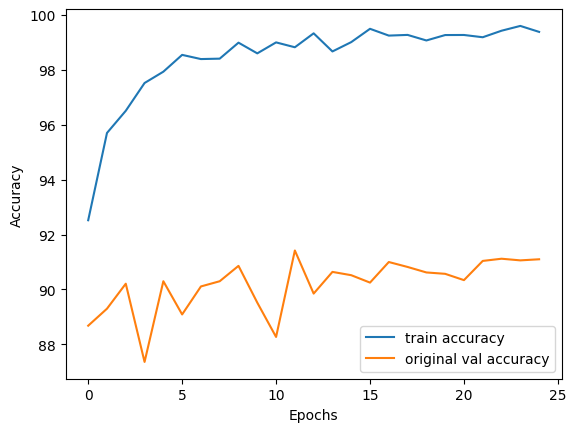

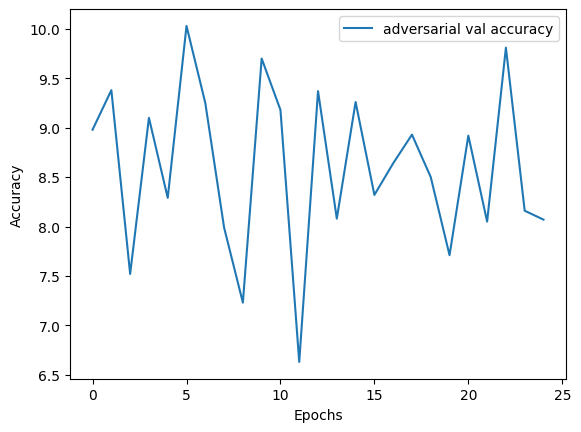

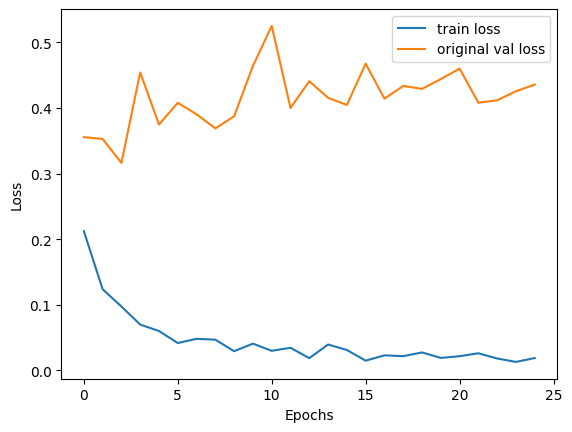

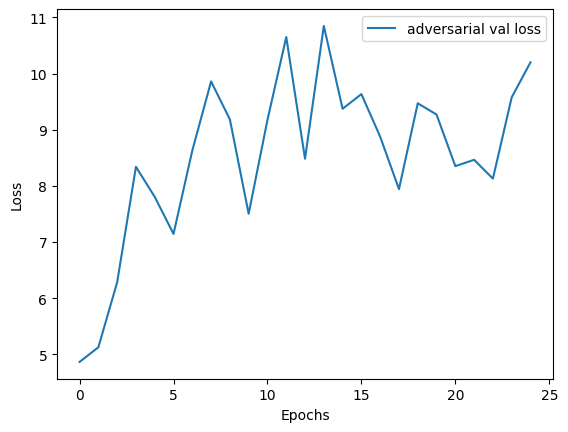

In [ ]:
plt.plot(train_accuracies,label='train accuracy')
plt.plot(val_accuracies_original,label='original val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(val_accuracies_adversarial,label='adversarial val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(train_losses,label='train loss')
plt.plot(val_losses_original,label='original val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.figure()
plt.plot(val_losses_adversarial,label='adversarial val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Test the model on original test images


In [ ]:
feature_output = []
def get_features_hook(module, input, output):
  global feature_output
  feature_output.append(output.cpu().detach().numpy())
model.avgpool.register_forward_hook(get_features_hook)

In [ ]:
all_labels = []
model.eval()
feature_output = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        all_labels.extend(labels.cpu().numpy())
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
features = np.concatenate(feature_output, axis=0)
all_labels = np.array(all_labels)
print(f'Accuracy of the model on the original test images: {accuracy}%')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the model on the original test images: 89.31%


In [ ]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=2, random_state=42)
embedding = reducer.fit_transform(features.reshape(features.shape[0], -1))

/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


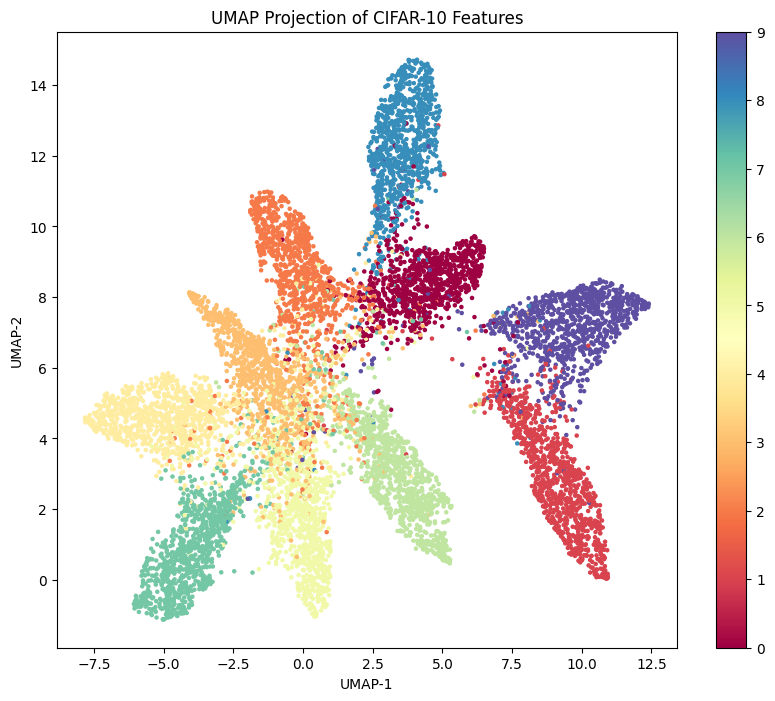

In [ ]:
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=all_labels, cmap='Spectral', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title('UMAP Projection of CIFAR-10 Features')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

## Test the model on adversarial test images

In [ ]:
def add_noise(batch):
  output_tensors = []
  for image in batch:
    C, H, W = image.shape
    for _ in range(20):
        # Randomly choose a pixel
        h, w = np.random.randint(0, H), np.random.randint(0, W)
        # Change the pixel color to white
        image[:, h, w] = torch.tensor([1.0, 1.0, 1.0])
    output_tensors.append(image)
  return torch.stack(output_tensors, 0)

all_labels = []
model.eval()
feature_output = []
correct = 0
total = 0
epsilon = 0.1

for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
  images, labels = data
  images, labels = images.to(device), labels.to(device)
  all_labels.extend(labels.cpu().numpy())
  data_fgm = fast_gradient_method(model, add_noise(images), epsilon, np.inf)
  outputs = model(data_fgm)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
features = np.concatenate(feature_output, axis=0)
all_labels = np.array(all_labels)
print()
print(f'Accuracy of the model on the adversarial test images: {accuracy}%')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 79/79 [01:11<00:00,  1.11it/s]



Accuracy of the model on the adversarial test images: 11.89%


In [ ]:
def add_noise(batch):
  output_tensors = []
  for image in batch:
    C, H, W = image.shape
    for _ in range(20):
        # Randomly choose a pixel
        h, w = np.random.randint(0, H), np.random.randint(0, W)
        # Change the pixel color to white
        image[:, h, w] = torch.tensor([1.0, 1.0, 1.0])
    output_tensors.append(image)
  return torch.stack(output_tensors, 0)

model_without_fc = torch.nn.Sequential(*(list(model.children())[:-1]))
model_without_fc.eval()
model.eval()
embeddings = []
labels = []
epsilon = 0.1
for images, targets in test_loader:
  images = images.to(device)
  targets = targets.to(device)
  data_fgm = fast_gradient_method(model, add_noise(images), epsilon, np.inf)
  with torch.no_grad():
    embeddings.append(torch.squeeze(model_without_fc(data_fgm)))
  labels.append(targets)
test_embeddings = torch.cat(embeddings)
test_labels = torch.cat(labels)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


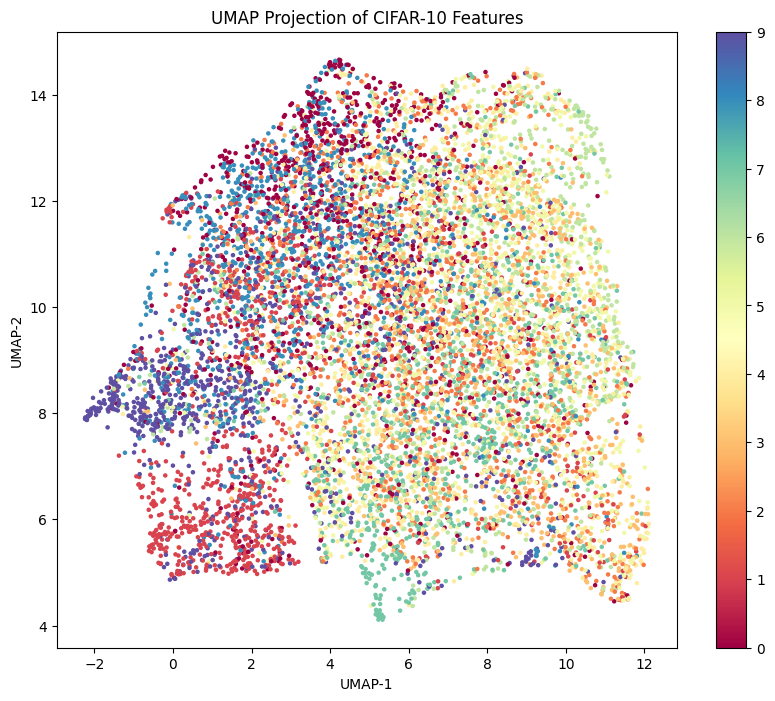

In [ ]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=2, random_state=42)
embedding = reducer.fit_transform(test_embeddings.cpu().numpy())
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=test_labels.cpu().numpy(), cmap='Spectral', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title('UMAP Projection of CIFAR-10 Features')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

## Train model on augmented dataset with CrossEntropy loss function

In [ ]:
def add_noise(batch):
  output_tensors = []
  for image in batch:
    C, H, W = image.shape
    for _ in range(20):
        # Randomly choose a pixel
        h, w = np.random.randint(0, H), np.random.randint(0, W)
        # Change the pixel color to white
        image[:, h, w] = torch.tensor([1.0, 1.0, 1.0])
    output_tensors.append(image)
  return torch.stack(output_tensors, 0)

def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 25
epsilon = 0.1

# Initialize lists for plotting
train_losses, val_losses_original, val_losses_adversarial, train_accuracies, val_accuracies_original, val_accuracies_adversarial = [], [], [], [], [], []

for epoch in range(epochs):
    model.train()
    print('Training')
    train_running_loss = 0.0
    train_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        if torch.rand(1).item() < 0.5:
          image = fast_gradient_method(model, add_noise(image), epsilon, np.inf) # Apply FGMS method with 50% probability
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(outputs, labels)
        train_running_loss += loss.item()
        # Calculate the accuracy.
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == labels).sum().item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()

    # Loss and accuracy for the complete epoch.
    epoch_loss = train_running_loss / counter
    epoch_acc = 100. * (train_running_correct / len(train_loader.dataset))
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)

    model.eval()
    print()
    print('Validation on original images')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        ### Original Validation images ###
        outputs = model(image)
        loss = criterion(outputs, labels)
        valid_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(valid_loader.dataset))
    val_losses_original.append(epoch_loss)
    val_accuracies_original.append(epoch_acc)

    print()
    print('Validation on adversarial images')
    valid_running_loss = 0.0
    valid_running_correct = 0
    counter = 0
    for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        ### Adversarial Validation images ###
        data_fgm = fast_gradient_method(model, add_noise(image), epsilon, np.inf)
        outputs = model(data_fgm)
        loss = criterion(outputs, labels)
        valid_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        valid_running_correct += (preds == labels).sum().item()

    # Loss and accuracy for the complete epoch.
    epoch_loss = valid_running_loss / counter
    epoch_acc = 100. * (valid_running_correct / len(valid_loader.dataset))
    val_losses_adversarial.append(epoch_loss)
    val_accuracies_adversarial.append(epoch_acc)

    print()
    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.2f}%, Val Loss_original: {val_losses_original[-1]:.4f}, Val Acc_original: {val_accuracies_original[-1]:.2f}%, Val Loss_adversarial: {val_losses_adversarial[-1]:.4f}, Val Acc_adversarial: {val_accuracies_adversarial[-1]:.2f}%')

    checkpoint(model, f"epoch-{epoch}.pth")

Training


100%|██████████| 313/313 [04:15<00:00,  1.22it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.89it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.13it/s]



Epoch 1, Train Loss: 0.7572, Train Acc: 72.59%, Val Loss_original: 0.5315, Val Acc_original: 81.37%, Val Loss_adversarial: 1.2954, Val Acc_adversarial: 52.26%
Training


100%|██████████| 313/313 [03:48<00:00,  1.37it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]



Epoch 2, Train Loss: 0.5280, Train Acc: 80.94%, Val Loss_original: 0.4830, Val Acc_original: 83.72%, Val Loss_adversarial: 0.7939, Val Acc_adversarial: 70.72%
Training


100%|██████████| 313/313 [03:43<00:00,  1.40it/s]


Validation on original images



100%|██████████| 79/79 [00:19<00:00,  4.03it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.13it/s]



Epoch 3, Train Loss: 0.4025, Train Acc: 85.43%, Val Loss_original: 0.4718, Val Acc_original: 84.83%, Val Loss_adversarial: 0.6413, Val Acc_adversarial: 76.89%
Training


100%|██████████| 313/313 [03:45<00:00,  1.39it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.94it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]



Epoch 4, Train Loss: 0.3154, Train Acc: 88.41%, Val Loss_original: 0.4695, Val Acc_original: 85.12%, Val Loss_adversarial: 0.5723, Val Acc_adversarial: 79.86%
Training


100%|██████████| 313/313 [03:41<00:00,  1.42it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.84it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]



Epoch 5, Train Loss: 0.2420, Train Acc: 91.09%, Val Loss_original: 0.5129, Val Acc_original: 84.72%, Val Loss_adversarial: 0.6480, Val Acc_adversarial: 77.90%
Training


100%|██████████| 313/313 [03:47<00:00,  1.37it/s]


Validation on original images



100%|██████████| 79/79 [00:19<00:00,  4.05it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.13it/s]



Epoch 6, Train Loss: 0.2076, Train Acc: 92.47%, Val Loss_original: 0.5729, Val Acc_original: 84.20%, Val Loss_adversarial: 0.7041, Val Acc_adversarial: 77.66%
Training


100%|██████████| 313/313 [03:38<00:00,  1.43it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.82it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]



Epoch 7, Train Loss: 0.1614, Train Acc: 93.97%, Val Loss_original: 0.4457, Val Acc_original: 87.19%, Val Loss_adversarial: 0.5656, Val Acc_adversarial: 81.24%
Training


100%|██████████| 313/313 [03:49<00:00,  1.36it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.13it/s]



Epoch 8, Train Loss: 0.1288, Train Acc: 95.24%, Val Loss_original: 0.4725, Val Acc_original: 86.38%, Val Loss_adversarial: 0.4561, Val Acc_adversarial: 85.83%
Training


100%|██████████| 313/313 [03:38<00:00,  1.43it/s]


Validation on original images



100%|██████████| 79/79 [00:19<00:00,  4.07it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.13it/s]



Epoch 9, Train Loss: 0.0944, Train Acc: 96.57%, Val Loss_original: 0.5317, Val Acc_original: 85.63%, Val Loss_adversarial: 0.5524, Val Acc_adversarial: 82.18%
Training


100%|██████████| 313/313 [03:39<00:00,  1.43it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]



Epoch 10, Train Loss: 0.0899, Train Acc: 96.97%, Val Loss_original: 0.4443, Val Acc_original: 86.28%, Val Loss_adversarial: 0.6030, Val Acc_adversarial: 78.45%
Training


100%|██████████| 313/313 [03:43<00:00,  1.40it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.13it/s]



Epoch 11, Train Loss: 0.0734, Train Acc: 97.35%, Val Loss_original: 0.6077, Val Acc_original: 85.22%, Val Loss_adversarial: 0.6270, Val Acc_adversarial: 82.45%
Training


100%|██████████| 313/313 [03:45<00:00,  1.39it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.89it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]



Epoch 12, Train Loss: 0.0580, Train Acc: 97.94%, Val Loss_original: 0.5101, Val Acc_original: 86.73%, Val Loss_adversarial: 0.5987, Val Acc_adversarial: 81.94%
Training


100%|██████████| 313/313 [03:44<00:00,  1.39it/s]


Validation on original images



100%|██████████| 79/79 [00:19<00:00,  3.99it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]



Epoch 13, Train Loss: 0.0562, Train Acc: 98.03%, Val Loss_original: 0.5638, Val Acc_original: 86.21%, Val Loss_adversarial: 0.6898, Val Acc_adversarial: 80.12%
Training


100%|██████████| 313/313 [03:44<00:00,  1.40it/s]


Validation on original images



100%|██████████| 79/79 [00:19<00:00,  4.00it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:10<00:00,  1.13it/s]



Epoch 14, Train Loss: 0.0570, Train Acc: 98.04%, Val Loss_original: 0.5481, Val Acc_original: 87.01%, Val Loss_adversarial: 0.6714, Val Acc_adversarial: 81.73%
Training


100%|██████████| 313/313 [03:46<00:00,  1.38it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.89it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]



Epoch 15, Train Loss: 0.0392, Train Acc: 98.74%, Val Loss_original: 0.5586, Val Acc_original: 86.83%, Val Loss_adversarial: 0.9017, Val Acc_adversarial: 75.89%
Training


100%|██████████| 313/313 [03:34<00:00,  1.46it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.90it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]



Epoch 16, Train Loss: 0.0382, Train Acc: 98.80%, Val Loss_original: 0.5564, Val Acc_original: 87.46%, Val Loss_adversarial: 1.0245, Val Acc_adversarial: 73.28%
Training


100%|██████████| 313/313 [03:36<00:00,  1.45it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.90it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]


Epoch 17, Train Loss: 0.0400, Train Acc: 98.71%, Val Loss_original: 0.5567, Val Acc_original: 88.12%, Val Loss_adversarial: 0.8268, Val Acc_adversarial: 79.56%
Training



100%|██████████| 313/313 [03:37<00:00,  1.44it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.93it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]



Epoch 18, Train Loss: 0.0483, Train Acc: 98.49%, Val Loss_original: 0.6005, Val Acc_original: 86.62%, Val Loss_adversarial: 0.7250, Val Acc_adversarial: 80.46%
Training


100%|██████████| 313/313 [03:43<00:00,  1.40it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]



Epoch 19, Train Loss: 0.0395, Train Acc: 98.66%, Val Loss_original: 0.5477, Val Acc_original: 88.19%, Val Loss_adversarial: 0.7038, Val Acc_adversarial: 80.84%
Training


100%|██████████| 313/313 [03:38<00:00,  1.43it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.89it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]



Epoch 20, Train Loss: 0.0263, Train Acc: 99.12%, Val Loss_original: 0.5893, Val Acc_original: 87.34%, Val Loss_adversarial: 0.8981, Val Acc_adversarial: 77.47%
Training


100%|██████████| 313/313 [03:49<00:00,  1.36it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.92it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]



Epoch 21, Train Loss: 0.0324, Train Acc: 98.95%, Val Loss_original: 0.6209, Val Acc_original: 86.45%, Val Loss_adversarial: 1.0538, Val Acc_adversarial: 74.18%
Training


100%|██████████| 313/313 [03:41<00:00,  1.41it/s]


Validation on original images



100%|██████████| 79/79 [00:19<00:00,  4.08it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]



Epoch 22, Train Loss: 0.0383, Train Acc: 98.74%, Val Loss_original: 0.5948, Val Acc_original: 87.79%, Val Loss_adversarial: 0.8912, Val Acc_adversarial: 77.55%
Training


100%|██████████| 313/313 [03:42<00:00,  1.41it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.90it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]



Epoch 23, Train Loss: 0.0314, Train Acc: 98.98%, Val Loss_original: 0.6637, Val Acc_original: 86.98%, Val Loss_adversarial: 1.0741, Val Acc_adversarial: 75.21%
Training


100%|██████████| 313/313 [03:30<00:00,  1.49it/s]


Validation on original images



100%|██████████| 79/79 [00:19<00:00,  3.99it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:09<00:00,  1.14it/s]



Epoch 24, Train Loss: 0.0256, Train Acc: 99.14%, Val Loss_original: 0.6772, Val Acc_original: 86.99%, Val Loss_adversarial: 0.8684, Val Acc_adversarial: 79.31%
Training


100%|██████████| 313/313 [03:47<00:00,  1.38it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.83it/s]


Validation on adversarial images



 96%|█████████▌| 76/79 [01:08<00:02,  1.18it/s]

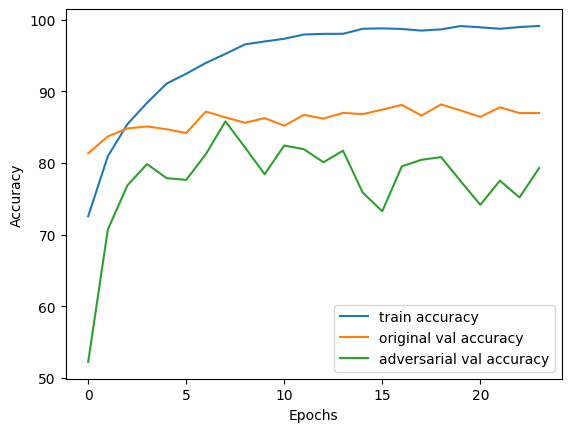

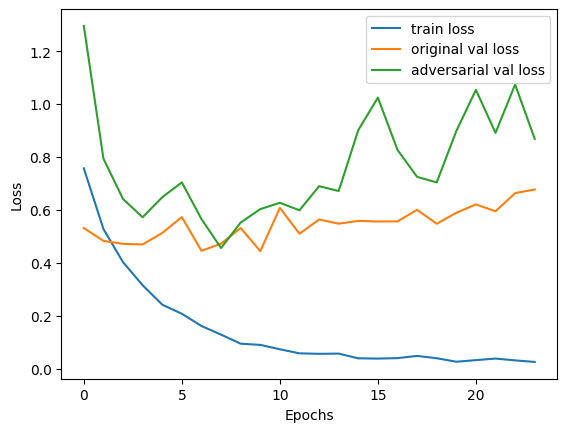

In [ ]:
train_accuracies = [72.59, 80.94, 85.43, 88.41, 91.09, 92.47, 93.97, 95.24, 96.57, 96.97, 97.35, 97.94, 98.03, 98.04, 98.74, 98.80, 98.71, 98.49, 98.66, 99.12, 98.95, 98.74, 98.98, 99.14]
val_accuracies_original =  [81.37, 83.72, 84.83, 85.12, 84.72, 84.20, 87.19, 86.38, 85.63, 86.28, 85.22, 86.73, 86.21, 87.01, 86.83, 87.46, 88.12, 86.62, 88.19, 87.34, 86.45, 87.79, 86.98, 86.99]
val_accuracies_adversarial = [52.26, 70.72, 76.89, 79.86, 77.90, 77.66, 81.24, 85.83, 82.18, 78.45, 82.45, 81.94, 80.12, 81.73, 75.89, 73.28, 79.56, 80.46, 80.84, 77.47, 74.18, 77.55, 75.21, 79.31]
train_losses = [0.7572, 0.5280, 0.4025, 0.3154, 0.2420, 0.2076, 0.1614, 0.1288, 0.0945, 0.0899, 0.0734, 0.0580, 0.0562, 0.0570, 0.0392, 0.0382, 0.0400, 0.0483, 0.0395, 0.0263, 0.0324, 0.0383, 0.0314, 0.0256]
val_losses_original = [0.5315, 0.4830, 0.4718, 0.4695, 0.5129, 0.5729, 0.4457, 0.4725, 0.5317, 0.4443, 0.6077, 0.5101, 0.5638, 0.5481, 0.5586, 0.5564, 0.5567, 0.6005, 0.5477, 0.5893, 0.6209, 0.5948, 0.6637, 0.6772]
val_losses_adversarial = [1.2954, 0.7939, 0.6413, 0.5723, 0.6480, 0.7041, 0.5656, 0.4561, 0.5524, 0.6030, 0.6270, 0.5987, 0.6898, 0.6714, 0.9017, 1.0245, 0.8268, 0.7250, 0.7038, 0.8981, 1.0538, 0.8912, 1.0741, 0.8684]
plt.plot(train_accuracies,label='train accuracy')
plt.plot(val_accuracies_original,label='original val accuracy')
plt.plot(val_accuracies_adversarial,label='adversarial val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.figure()
plt.plot(train_losses,label='train loss')
plt.plot(val_losses_original,label='original val loss')
plt.plot(val_losses_adversarial,label='adversarial val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Test the model on original test images


In [ ]:
feature_output = []
def get_features_hook(module, input, output):
  global feature_output
  feature_output.append(output.cpu().detach().numpy())
model.avgpool.register_forward_hook(get_features_hook)

In [ ]:
all_labels = []
model.eval()
feature_output = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        all_labels.extend(labels.cpu().numpy())
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
features = np.concatenate(feature_output, axis=0)
all_labels = np.array(all_labels)
print(f'Accuracy of the model on the original test images: {accuracy}%')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Accuracy of the model on the original test images: 87.33%


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


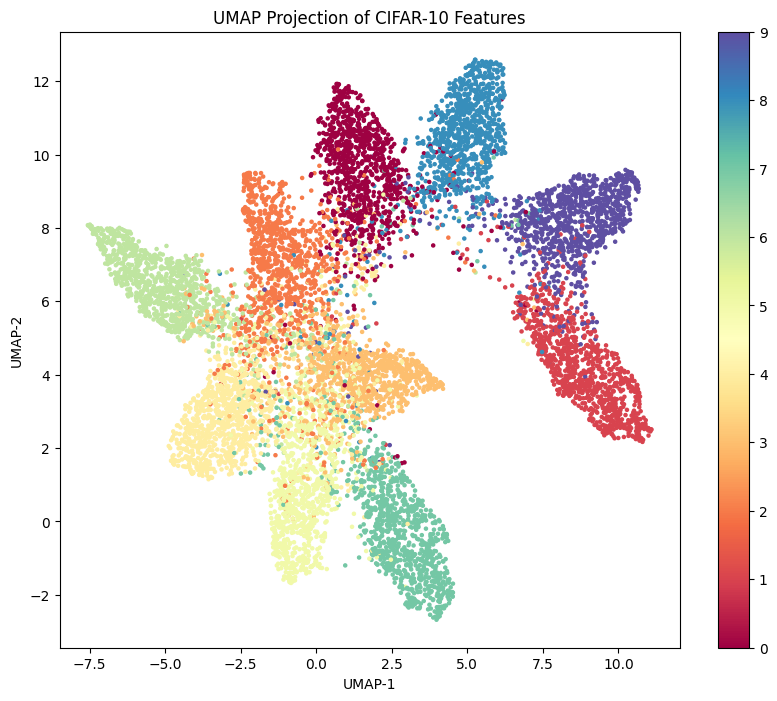

In [ ]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=2, random_state=42)
embedding = reducer.fit_transform(features.reshape(features.shape[0], -1))
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=all_labels, cmap='Spectral', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title('UMAP Projection of CIFAR-10 Features')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

## Test the model on adversarial test images


In [ ]:
def add_noise(batch):
  output_tensors = []
  for image in batch:
    C, H, W = image.shape
    for _ in range(20):
        # Randomly choose a pixel
        h, w = np.random.randint(0, H), np.random.randint(0, W)
        # Change the pixel color to white
        image[:, h, w] = torch.tensor([1.0, 1.0, 1.0])
    output_tensors.append(image)
  return torch.stack(output_tensors, 0)

all_labels = []
model.eval()
feature_output = []
correct = 0
total = 0
epsilon = 0.1

for i, data in tqdm(enumerate(test_loader), total=len(test_loader)):
  images, labels = data
  images, labels = images.to(device), labels.to(device)
  all_labels.extend(labels.cpu().numpy())
  data_fgm = fast_gradient_method(model, add_noise(images), epsilon, np.inf)
  outputs = model(data_fgm)
  _, predicted = torch.max(outputs.data, 1)
  total += labels.size(0)
  correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
features = np.concatenate(feature_output, axis=0)
all_labels = np.array(all_labels)
print()
print(f'Accuracy of the model on the adversarial test images: {accuracy}%')

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 79/79 [01:12<00:00,  1.74it/s]/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
100%|██████████| 79/79 [01:12<00:00,  1.09it/s]



Accuracy of the model on the adversarial test images: 79.65%


In [9]:
def add_noise(batch):
  output_tensors = []
  for image in batch:
    C, H, W = image.shape
    for _ in range(20):
        # Randomly choose a pixel
        h, w = np.random.randint(0, H), np.random.randint(0, W)
        # Change the pixel color to white
        image[:, h, w] = torch.tensor([1.0, 1.0, 1.0])
    output_tensors.append(image)
  return torch.stack(output_tensors, 0)

model_without_fc = torch.nn.Sequential(*(list(model.children())[:-1]))
model_without_fc.eval()
model.eval()
embeddings = []
labels = []
epsilon = 0.1
for images, targets in test_loader:
  images = images.to(device)
  targets = targets.to(device)
  data_fgm = fast_gradient_method(model, add_noise(images), epsilon, np.inf)
  with torch.no_grad():
    embeddings.append(torch.squeeze(model_without_fc(data_fgm)))
  labels.append(targets)
test_embeddings = torch.cat(embeddings)
test_labels = torch.cat(labels)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


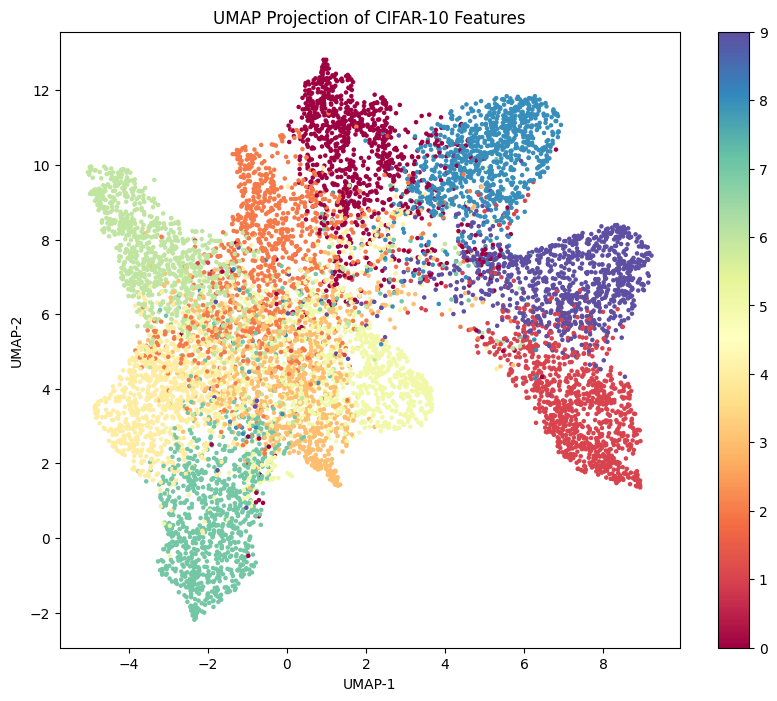

In [10]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=2, random_state=42)
embedding = reducer.fit_transform(test_embeddings.cpu().numpy())
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=test_labels.cpu().numpy(), cmap='Spectral', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title('UMAP Projection of CIFAR-10 Features')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

## Train model on original dataset with CircleLoss

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = models.resnet18(pretrained=True)
num_classes = 10
model.fc = torch.nn.Linear(model.fc.in_features, num_classes)
model = model.to(device)
model = torch.nn.Sequential(*(list(model.children())[:-1]))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 166MB/s]


In [ ]:
def add_noise(batch):
  output_tensors = []
  for image in batch:
    C, H, W = image.shape
    for _ in range(20):
        # Randomly choose a pixel
        h, w = np.random.randint(0, H), np.random.randint(0, W)
        # Change the pixel color to white
        image[:, h, w] = torch.tensor([1.0, 1.0, 1.0])
    output_tensors.append(image)
  return torch.stack(output_tensors, 0)

def checkpoint(model, filename):
    torch.save(model.state_dict(), filename)

criterion = losses.CircleLoss(m=0.4, gamma=80)
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 20
epsilon = 0.1

# Initialize lists for plotting
train_losses, val_losses_original, val_losses_adversarial = [], [], []

for epoch in range(epochs):
    model.train()
    print('Training')
    train_running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(train_loader), total=len(train_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        # Forward pass.
        outputs = model(image)
        # Calculate the loss.
        loss = criterion(torch.squeeze(outputs), labels)
        train_running_loss += loss.item()
        # Backpropagation
        loss.backward()
        # Update the weights.
        optimizer.step()

    # Loss for the complete epoch.
    epoch_loss = train_running_loss / counter
    train_losses.append(epoch_loss)

    model.eval()
    print()
    print('Validation on original images')
    valid_running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        ### Original Validation images ###
        outputs = model(image)
        loss = criterion(torch.squeeze(outputs), labels)
        valid_running_loss += loss.item()

    # Loss for the complete epoch.
    epoch_loss = valid_running_loss / counter
    val_losses_original.append(epoch_loss)

    print()
    print('Validation on adversarial images')
    valid_running_loss = 0.0
    counter = 0
    for i, data in tqdm(enumerate(valid_loader), total=len(valid_loader)):
        counter += 1
        image, labels = data
        image = image.to(device)
        labels = labels.to(device)

        ### Adversarial Validation images ###
        data_fgm = fast_gradient_method(model, add_noise(image), epsilon, np.inf)
        outputs = model(data_fgm)
        loss = criterion(torch.squeeze(outputs), labels)
        valid_running_loss += loss.item()

    # Loss for the complete epoch.
    epoch_loss = valid_running_loss / counter
    val_losses_adversarial.append(epoch_loss)

    print()
    print(f'Epoch {epoch+1}, Train Loss: {train_losses[-1]:.4f}, Val Loss_original: {val_losses_original[-1]:.4f}, Val Loss_adversarial: {val_losses_adversarial[-1]:.4f}')
    checkpoint(model, f"epoch-{epoch}-circle.pth")

Training


100%|██████████| 313/313 [02:03<00:00,  2.53it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.87it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.09it/s]


Epoch 1, Train Loss: 30.1076, Val Loss_original: 29.9762, Val Loss_adversarial: 41.0945
Training



100%|██████████| 313/313 [01:59<00:00,  2.61it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.94it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:11<00:00,  1.10it/s]



Epoch 2, Train Loss: 27.6936, Val Loss_original: 28.0705, Val Loss_adversarial: 41.8628
Training


100%|██████████| 313/313 [01:59<00:00,  2.61it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.76it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.10it/s]


Epoch 3, Train Loss: 25.9119, Val Loss_original: 28.5380, Val Loss_adversarial: 41.9295
Training



100%|██████████| 313/313 [01:59<00:00,  2.61it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.09it/s]


Epoch 4, Train Loss: 24.3170, Val Loss_original: 27.2248, Val Loss_adversarial: 40.5360
Training



100%|██████████| 313/313 [01:59<00:00,  2.61it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.86it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.09it/s]



Epoch 5, Train Loss: 22.0887, Val Loss_original: 30.1561, Val Loss_adversarial: 44.7565
Training


100%|██████████| 313/313 [01:59<00:00,  2.61it/s]


Validation on original images



100%|██████████| 79/79 [00:29<00:00,  2.67it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:16<00:00,  1.03it/s]



Epoch 6, Train Loss: 19.8429, Val Loss_original: 29.5161, Val Loss_adversarial: 49.1519
Training


100%|██████████| 313/313 [02:00<00:00,  2.60it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.70it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.09it/s]



Epoch 7, Train Loss: 17.8671, Val Loss_original: 27.4834, Val Loss_adversarial: 45.1204
Training


100%|██████████| 313/313 [02:00<00:00,  2.60it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.85it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.09it/s]


Epoch 8, Train Loss: 15.5037, Val Loss_original: 31.5325, Val Loss_adversarial: 48.3292
Training



100%|██████████| 313/313 [01:59<00:00,  2.61it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.73it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.09it/s]


Epoch 9, Train Loss: 13.0723, Val Loss_original: 31.7239, Val Loss_adversarial: 57.5431
Training



100%|██████████| 313/313 [01:59<00:00,  2.61it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.71it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:11<00:00,  1.10it/s]



Epoch 10, Train Loss: 10.4180, Val Loss_original: 36.4754, Val Loss_adversarial: 63.1436
Training


100%|██████████| 313/313 [02:00<00:00,  2.61it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.89it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.09it/s]



Epoch 11, Train Loss: 9.0307, Val Loss_original: 34.2336, Val Loss_adversarial: 65.5861
Training


100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.69it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:11<00:00,  1.10it/s]


Epoch 12, Train Loss: 7.7901, Val Loss_original: 38.0698, Val Loss_adversarial: 66.2240
Training



100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.68it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.10it/s]



Epoch 13, Train Loss: 6.6292, Val Loss_original: 36.8539, Val Loss_adversarial: 67.8610
Training


100%|██████████| 313/313 [02:00<00:00,  2.60it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.88it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.08it/s]


Epoch 14, Train Loss: 5.5658, Val Loss_original: 40.8921, Val Loss_adversarial: 71.6348
Training



100%|██████████| 313/313 [01:59<00:00,  2.62it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.68it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.09it/s]


Epoch 15, Train Loss: 4.8942, Val Loss_original: 44.7272, Val Loss_adversarial: 75.3875
Training



100%|██████████| 313/313 [01:59<00:00,  2.61it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.63it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.09it/s]



Epoch 16, Train Loss: 4.1510, Val Loss_original: 41.1702, Val Loss_adversarial: 73.8305
Training


100%|██████████| 313/313 [01:59<00:00,  2.61it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.84it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.09it/s]



Epoch 17, Train Loss: 3.3823, Val Loss_original: 44.4907, Val Loss_adversarial: 69.2543
Training


100%|██████████| 313/313 [01:59<00:00,  2.61it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.67it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.09it/s]


Epoch 18, Train Loss: 2.5544, Val Loss_original: 42.8133, Val Loss_adversarial: 73.7664
Training



100%|██████████| 313/313 [01:59<00:00,  2.61it/s]


Validation on original images



100%|██████████| 79/79 [00:21<00:00,  3.65it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.10it/s]



Epoch 19, Train Loss: 2.2076, Val Loss_original: 44.3337, Val Loss_adversarial: 71.2880
Training


100%|██████████| 313/313 [02:00<00:00,  2.61it/s]


Validation on original images



100%|██████████| 79/79 [00:20<00:00,  3.89it/s]


Validation on adversarial images



100%|██████████| 79/79 [01:12<00:00,  1.09it/s]


Epoch 20, Train Loss: 2.7251, Val Loss_original: 44.8213, Val Loss_adversarial: 79.9154


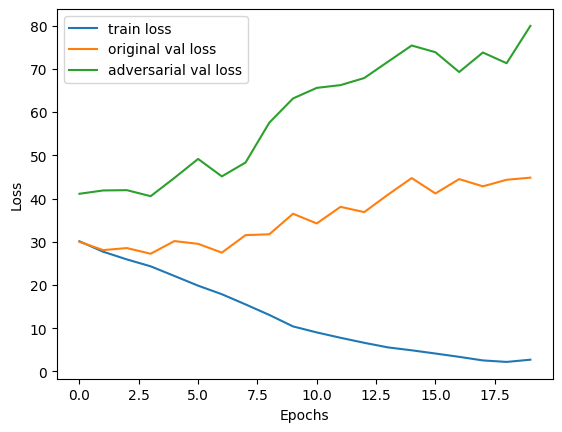

In [ ]:
plt.figure()
plt.plot(train_losses,label='train loss')
plt.plot(val_losses_original,label='original val loss')
plt.plot(val_losses_adversarial,label='adversarial val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

## Building KNN classifier with embeddings of train images

In [ ]:
### Get embeddings of train images ###
model.eval()
embeddings = []
labels = []
with torch.no_grad():
  for images, targets in train_loader:
    images = images.to(device)
    targets = targets.to(device)
    features = torch.squeeze(model(images))
    embeddings.append(features)
    labels.append(targets)
train_embeddings = torch.cat(embeddings)
train_labels = torch.cat(labels)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
train_embeddings = train_embeddings.view(train_embeddings.size(0), -1)
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(train_embeddings.cpu().numpy(), train_labels.cpu().numpy())

KNeighborsClassifier(n_neighbors=3)

## Test the model on original test images


In [ ]:
### Get embeddings of original test images ###
model.eval()
embeddings = []
labels = []
with torch.no_grad():
  for images, targets in test_loader:
    images = images.to(device)
    targets = targets.to(device)
    features = torch.squeeze(model(images))
    embeddings.append(features)
    labels.append(targets)
test_embeddings = torch.cat(embeddings)
test_labels = torch.cat(labels)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
test_embeddings = test_embeddings.view(test_embeddings.size(0), -1)
predictions = knn.predict(test_embeddings.cpu().numpy())
accuracy = accuracy_score(test_labels.cpu().numpy(), predictions)
print("Test Accuracy on original test images:", accuracy)

Test Accuracy on original test images: 0.8952


/usr/local/lib/python3.10/dist-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


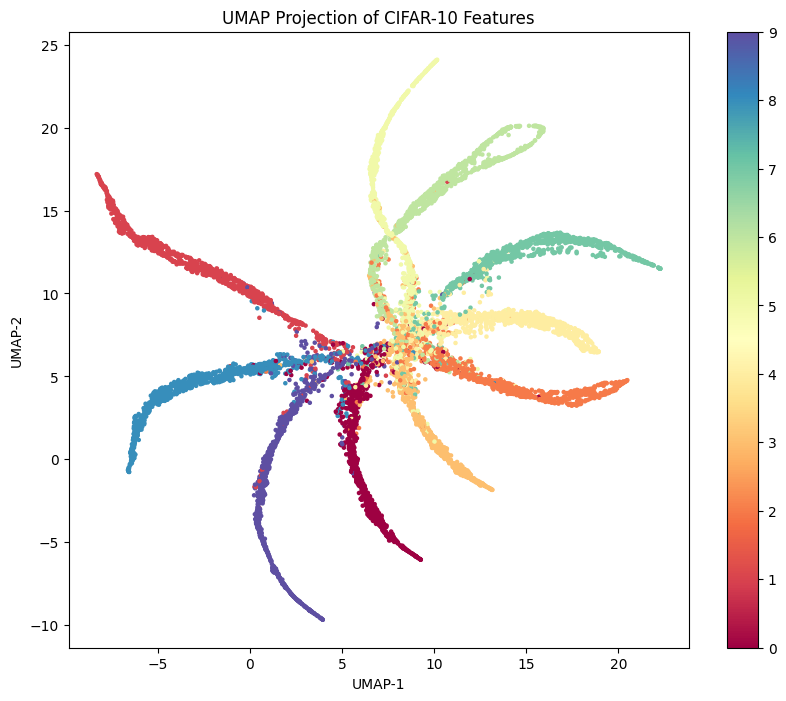

In [ ]:
reducer = umap.UMAP(n_neighbors=10, min_dist=0.3, n_components=2, random_state=42)
embedding = reducer.fit_transform(test_embeddings.cpu().numpy())
plt.figure(figsize=(10, 8))
scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=test_labels.cpu().numpy(), cmap='Spectral', s=5)
plt.colorbar(scatter, ticks=range(10))
plt.title('UMAP Projection of CIFAR-10 Features')
plt.xlabel('UMAP-1')
plt.ylabel('UMAP-2')
plt.show()

## Test the model on adversarial test images


In [ ]:
### Get embeddings of adversarial test images and predicting with KNN classifier ###
def add_noise(batch):
  output_tensors = []
  for image in batch:
    C, H, W = image.shape
    for _ in range(20):
        # Randomly choose a pixel
        h, w = np.random.randint(0, H), np.random.randint(0, W)
        # Change the pixel color to white
        image[:, h, w] = torch.tensor([1.0, 1.0, 1.0])
    output_tensors.append(image)
  return torch.stack(output_tensors, 0)

test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, num_workers=2)
epsilon = 0.1
model.eval()
embeddings = []
labels = []
predicted_labels = []
for images, targets in test_loader:
  images = images.to(device)
  targets = targets.to(device)
  data_fgm = fast_gradient_method(model, add_noise(images), epsilon, np.inf)
  features = torch.squeeze(model(data_fgm))
  predictions = knn.predict(features.detach().cpu().numpy())
  labels.append(targets)
  predicted_labels.append(list(predictions))
predicted_labels = [element for sublist in predicted_labels for element in sublist]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


In [ ]:
test_labels = torch.cat(labels)
accuracy = accuracy_score(test_labels.cpu().numpy(), predicted_labels)
print("Test Accuracy on adversarial test images:", accuracy)

Test Accuracy on adversarial test images: 0.0728
